# Training a CNN to do 10 class classification of the STL10 dataset
Using the subroutine stl10_input by Martin Tutek in link https://cs.stanford.edu/~acoates/stl10/

In [1]:
from stl10_input import *
import pandas as pd
import os
%matplotlib inline

sys.version_info(major=3, minor=6, micro=3, releaselevel='final', serial=0)


In [2]:
#Import Keras.
from matplotlib import pyplot
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [8]:
path_to_data='./data/stl10_binary/train_X.bin'
path_to_labels='./data/stl10_binary/train_y.bin'
images=read_all_images(path_to_data)
labels=read_labels(path_to_labels)
N=images.shape[0]
print(images.shape, labels.shape)

(5000, 96, 96, 3) (5000,)


There are 5000 training images. Each RGB image is 96x96

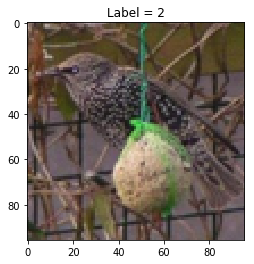

In [9]:
ii=20
plot_image(images[ii,:],labels[ii])

Normalize the data (0-1) and verifiy images look unharmed

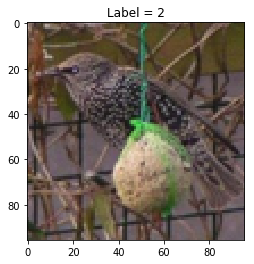

In [10]:
# normalize inputs from 0-255 to 0.0-1.0
images = images.astype('float32')
images = images / 255.0
ii=20
plot_image(images[ii,:],labels[ii])

For parameter tuning, I used the cross validation sets in https://cs.stanford.edu/~acoates/stl10/
Read the training indcies file for each trainig validation set. It is 10 fold, each with 1000 training images. 

In [11]:
file_indices='./data/stl10_binary/fold_indices.txt'
idxtrain=pd.read_table(file_indices, header=None, sep=" ")
idxtrain.dropna(axis=1, inplace=True)
idxtrain.apply(pd.to_numeric)
print(idxtrain.shape, np.max(np.max(idxtrain)), np.min(np.min(idxtrain)))
idxtrain

(10, 1000) 4999 0


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,39,4948,2964,2855,1866,1306,2954,1040,2450,1829,...,3286,3239,2561,3463,735,4171,4532,1405,2918,4930
1,2568,1657,2871,579,3380,1484,4372,2989,2126,2947,...,3745,1319,19,163,2829,4091,1489,2555,3176,2634
2,1355,3916,3348,3417,2726,3245,41,3239,313,1053,...,1136,89,2167,3354,846,849,2823,4914,2491,426
3,2373,2831,950,4558,832,142,3940,2563,656,937,...,14,3333,1601,1962,477,3912,2363,68,815,1226
4,1632,1914,1739,4639,1009,4160,4035,2197,2513,4705,...,3497,3540,1654,2899,2508,3850,1121,3042,4757,3733
5,3771,4715,3997,3070,1761,1449,1072,2169,4034,340,...,920,2973,2753,3010,1307,1459,2388,1126,4618,1273
6,4238,4712,2526,3864,2139,4050,3996,2428,1806,3351,...,1220,4267,1966,316,3574,4079,478,32,2383,2943
7,1256,2554,292,2766,4474,2923,4631,2857,1641,1745,...,3564,967,1184,4168,857,339,2410,185,3543,696
8,987,190,3556,4805,4643,698,3003,3977,2969,2259,...,1234,968,4179,2089,505,4903,4935,1132,907,3411
9,2570,1868,4671,631,3831,488,4305,2339,3324,3155,...,2902,1516,1273,3477,3392,2118,4311,2654,1544,261


In [12]:
#create train/test datasets from indices
def create_train_val(images, labels, index_train):
    N,L,L,d=images.shape
    flat1=images.reshape(N,L*L*d)
    index_train=np.array(index_train)
    idt=np.array([1 if i in index_train else 0 for i in range(N)])
    train_im=flat1[idt==1].reshape((sum(idt==1),L,L,d))
    val_im=flat1[idt==0].reshape((sum(idt==0),L,L,d))
    train_label=np.array(labels[idt==1]).reshape((sum(idt==1),1))
    val_label=np.array(labels[idt==0]).reshape((sum(idt==0),1))
    #one hot encode
    train_label = np_utils.to_categorical(train_label-1)  #make it start from 0
    val_label = np_utils.to_categorical(val_label-1)  
    num_classes = train_label.shape[1]
    #print('Training size' , train_im.shape, train_label.shape, 'Validation size', test_im.shape, test_label.shape, num_classes)
    return train_im, train_label, val_im, val_label

Create the CNN architecture. 
There are 1,125,418 trainable parameters.

In [33]:
#define our model
def getModel():
    
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(96, 96, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))  
    model.add(Dropout(0.2))

    model.add(Conv2D(32,(3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
 
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
 
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10))
    model.add(Activation('softmax'))
 
  

    mypotim=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss='categorical_crossentropy',
                  optimizer=mypotim,
                  metrics=['accuracy'])
    model.summary()
    return model


def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]
file_path = ".model_weights.hdf5"
callbacks = get_callbacks(filepath=file_path, patience=10)


Some hyper parameter training, over learning rate and batch size. Not all here.

In [17]:
cv_train_acc=[]
cv_val_acc=[]
folds=1
for k in range(folds):
    X_train_cv, y_train_cv, X_valid_cv, y_valid_cv  =create_train_val(images, labels, idxtrain.iloc[k])
    print('-----   Fold -----  ',k)
    #print('Training', X_train_cv.shape,y_train_cv.shape)
    #print('Validating', X_valid_cv.shape,y_valid_cv.shape)
    gmodel=getModel(LR=0.001*k)
    mod1=gmodel.fit(X_train_cv, y_train_cv,
          batch_size=100,
          epochs=5,
          verbose=1,
          validation_data=(X_valid_cv, y_valid_cv),
          callbacks=callbacks)
    cv_train_acc.append(np.max(mod1.history['acc']))
    cv_val_acc.append(np.max(mod1.history['val_acc']))   
print(cv_val_acc)#print(cv_train_acc)
print('Mean validation acc. ', np.mean(cv_val_acc),'  ', np.std(cv_train_acc),'  --Mean training acc.   ',   np.mean(cv_train_acc), '  ',np.std(cv_train_acc) )

-----   Fold -----   0
Train on 1000 samples, validate on 4000 samples
Epoch 1/5
1000/1000 [==============================] - 357s - loss: 2.7845 - acc: 0.1610 - val_loss: 2.2824 - val_acc: 0.1332
Epoch 2/5
1000/1000 [==============================] - 353s - loss: 2.6073 - acc: 0.1830 - val_loss: 2.2270 - val_acc: 0.1560
Epoch 3/5
1000/1000 [==============================] - 353s - loss: 2.4221 - acc: 0.2130 - val_loss: 2.1732 - val_acc: 0.2607
Epoch 4/5
1000/1000 [==============================] - 363s - loss: 2.1911 - acc: 0.2700 - val_loss: 2.1785 - val_acc: 0.1857
Epoch 5/5
1000/1000 [==============================] - 352s - loss: 2.0038 - acc: 0.3360 - val_loss: 2.1791 - val_acc: 0.1440
[0.26074999794363973]
Mean validation acc.  0.260749997944    0.0   --Mean training acc.    0.33599999696    0.0


Train final model after doing a little hyper parameters over learning rate and batch size.
Accuracy should be around 0.1 before training, since there are 10 classes. 

In [34]:
ready_final_train=1
if ready_final_train==1:
    path_to_test_data='./data/stl10_binary/test_X.bin'
    path_to_test_label='./data/stl10_binary/test_y.bin'
    test_images=read_all_images(path_to_test_data)
    test_labels=read_labels(path_to_test_label)
    test_images = test_images.astype('float32') # normalize inputs from 0-255 to 0.0-1.0
    test_images = test_images / 255.0
    #one hot encoding
    test_labels = np_utils.to_categorical(test_labels-1)  
    train_labels = np_utils.to_categorical(labels-1)  
    gmodel=getModel()
    mod2=gmodel.fit(images, train_labels,
          batch_size=40,
          epochs=30,
          verbose=1,
          validation_data=(test_images, test_labels),
          callbacks=callbacks)
    print(mod2.history['val_acc'])
    print(mod2.history['val_acc'][-1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_53 (Conv2D)           (None, 94, 94, 32)        896       
_________________________________________________________________
activation_79 (Activation)   (None, 94, 94, 32)        0         
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 47, 47, 32)        0         
_________________________________________________________________
dropout_66 (Dropout)         (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 45, 45, 32)        9248      
_________________________________________________________________
activation_80 (Activation)   (None, 45, 45, 32)        0         
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 22, 22, 32)        0         
__________

Plots of loss and accuracy over training and test datasets. 
We can see there are signs of overfitting, indicating more hyperparameter tuning is needed. 
This could include: adding regularization,  reducing the model complexitity,..

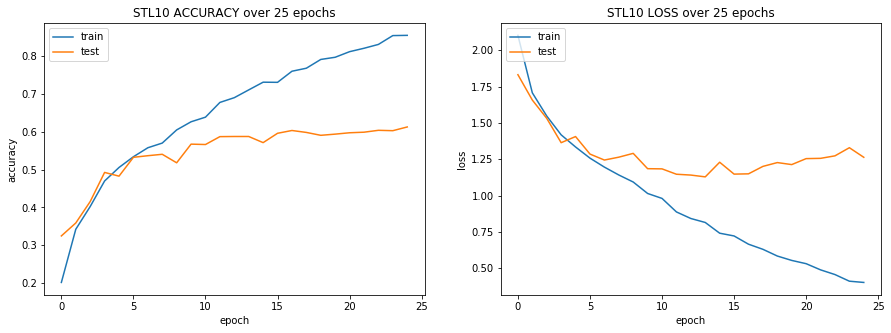

In [40]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(mod2.history['acc'])
plt.plot(mod2.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.title('STL10 ACCURACY over 25 epochs')

plt.subplot(122)
plt.plot(mod2.history['loss'])
plt.plot(mod2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.title('STL10 LOSS over 25 epochs')
plt.show()